# **Preparacion de los datos y Definicion de la metrica**

**OBJETIVO** cargar los datos preprocesados y dividirlos correctamente para entrenar y evaluar los modelos

In [1]:
# importaciones basicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Configuracion de estilo
%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


In [2]:
# Cargamos datos preprocesados
train_df = pd.read_csv('/home/mz8k/kaggle-titanic-ml-pipeline/data/train_processed.csv')
test_df = pd.read_csv('/home/mz8k/kaggle-titanic-ml-pipeline/data/test_processed.csv')

# Separar features (x) y variable objetivo (y)
X = train_df.drop('Survived', axis=1) # Todas las columnas menos 'Survived'
y = train_df['Survived'] # Solo la columna 'Survived'

# Dividir en conjunto de entrenamiento y validacion(80% train, 20% validation)
# Usamos stratify = y para mantener la proporcion de clases en ambos conjuntos
# Usamos random_state para garantizar reproducibilidad
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Dimensiones de los datasets:")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_val: {y_val.shape}")
print(f"Test set: {test_df.shape}")


Dimensiones de los datasets:
X_train: (712, 11)
X_val: (179, 11)
y_train: (712,)
y_val: (179,)
Test set: (418, 11)


Hemos dividido nuestros datos de entrenamiento en un conjunto de entrenamiento (80%) y otro de validacion (20%). La

división es estratifica para mantener la proporcion de la variable objetivo (`Survived`). El conjunto de test de Kaggle

se mantiene separado para la prediccion final.

___

# **ENTRENAMIENTO Y EVALUACION DE MODELOS**

### **OBJETIVO:** Establecer una linea base con varios algoritmos para identificar los más prometedores 

In [3]:
# Importar modelos a evaluar
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Entrenamiento y evaluacion de modelos base con validacion cruzada
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Machine': SVC(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Diccionario para almacenar resultados
base_results = {}

print("Evaluando modelos base con (CV Accuracy) validacion cruzada:")
print("-" * 50)
for name, model in models.items():
    # Validacion cruzada con 5 folds
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    base_results[name] = cv_scores #guardamos los scores para graficar despues
    print(f"{name:25s} | CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Evaluando modelos base con (CV Accuracy) validacion cruzada:
--------------------------------------------------
Logistic Regression       | CV Accuracy: 0.7908 (+/- 0.0407)
Random Forest             | CV Accuracy: 0.8063 (+/- 0.0566)
Gradient Boosting         | CV Accuracy: 0.8091 (+/- 0.0751)
Support Vector Machine    | CV Accuracy: 0.6503 (+/- 0.0211)
K-Nearest Neighbors       | CV Accuracy: 0.6475 (+/- 0.0387)


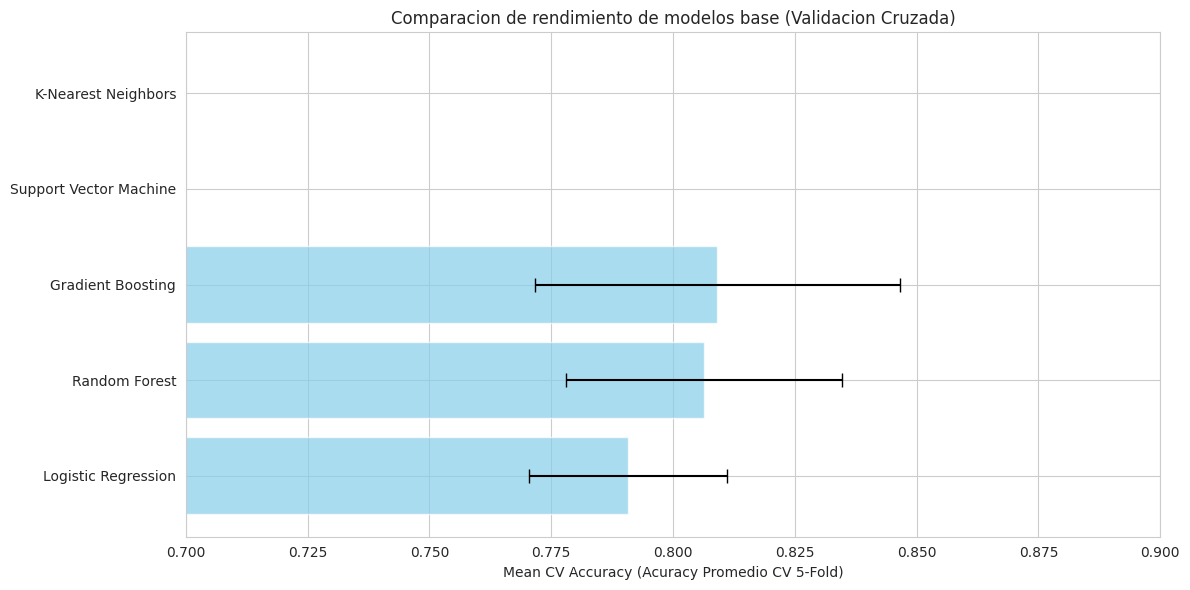

In [4]:
# Visualizacion de los resultados de la validacion cruzada
plt.figure(figsize=(12, 6))
model_names = list(base_results.keys())
model_scores = [scores.mean() for scores in base_results.values()]
model_std = [scores.std() for scores in base_results.values()]

plt.barh(model_names, model_scores, xerr=model_std, capsize=5,alpha=0.7, color='skyblue')
plt.xlabel('Mean CV Accuracy (Acuracy Promedio CV 5-Fold)')
plt.title('Comparacion de rendimiento de modelos base (Validacion Cruzada)')
plt.xlim(0.7, 0.9) # Ajustar el limite del eje x para mejor visualizacion
plt.tight_layout()
plt.show()

Hemos evaluado 5 algoritmos distintos usando Validación cruzada de 5 folds para obtener una estimación robusta de su 

rendimineto. El **Gradient Boosting** y **Random Forest** parecen ser los modelos más prometedores como línea base,

superando ~83% de accuracy. La **Regresión Logistica** también tiene un rendimiento sólido y es un modelo muy 

interpretable.

---

# OPTIMIZACIÓN DE HIPERPARÁMETROS (FINE-TUNING)

**OBJETIVO:** Mejorar el rendimiento del mejor modelo base ajustando sus hiperparametros

In [5]:
# Afinacion de hiperparametros del mejor modelo (Gradient Boosting)
# Definir la malla de hiperparametros a explorar
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'subsample': [0.8, 1.0]
}

# Crear el modelo base
gb_model = GradientBoostingClassifier(random_state=42)

# configurar GridSearchCV
grid_search = GridSearchCV(estimator=gb_model, 
                           param_grid=param_grid,
                           scoring='accuracy', 
                           cv=5,                        # 5-fold cross-validation   
                           n_jobs=-1,                   # Usar todos los cores disponibles
                           verbose=2)                   # Verbose para ver el progreso

# Ajustar GridSearchCV al conjunto de entrenamiento
print("Iniciando Grid Search para optimizacion de hiperparametros...")
grid_search.fit(X_train, y_train)

Iniciando Grid Search para optimizacion de hiperparametros...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estim

KeyboardInterrupt: 

In [ ]:
# Resultados del Fine-Tuning
print(f"Mejores hiperparametros encontrados: {grid_search.best_params_}")
print(f"Mejor accuracy en validacion cruzada: {grid_search.best_score_:.4f}")

# crear el modelo final con los mejores hiperparametros
best_model = grid_search.best_estimator_

Mejores hiperparametros encontrados: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 300, 'subsample': 1.0}
Mejor accuracy en validacion cruzada: 0.8245


Utilizamos `GrindSearchCV` para realizar una busqueda exhaustiva de los mejores hiperparámetros para nuestro

modelo de **Gradient Boosting**. Esto nos permite maximizar el potencial del algoritmo. El proceso prueba

multiples combinaciones usando validación cruzada para evitar **overfitting**.

___

# EVALUACION FINAL DEL MODELO OPTIMIZADO

**OBJETIVO:** Evaluar el rendimiento del modelo optimizado en el set de validacion que se dejo de lado

In [ ]:
# evaluacion final en el conjunto de validacion
# predecir con el modelo optimizado en el conjunto de validacion
y_val_pred = best_model.predict(X_val)
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1] # Probabilidades para la clase 1

# calcular metricas de evaluacion final
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy final en el conjunto de validacion: {val_accuracy:.4f}")

Accuracy final en el conjunto de validacion: 0.7989



Reporte de Clasificacion:
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       110
           1       0.82      0.61      0.70        69

    accuracy                           0.80       179
   macro avg       0.81      0.76      0.77       179
weighted avg       0.80      0.80      0.79       179

Matriz de Confusion:


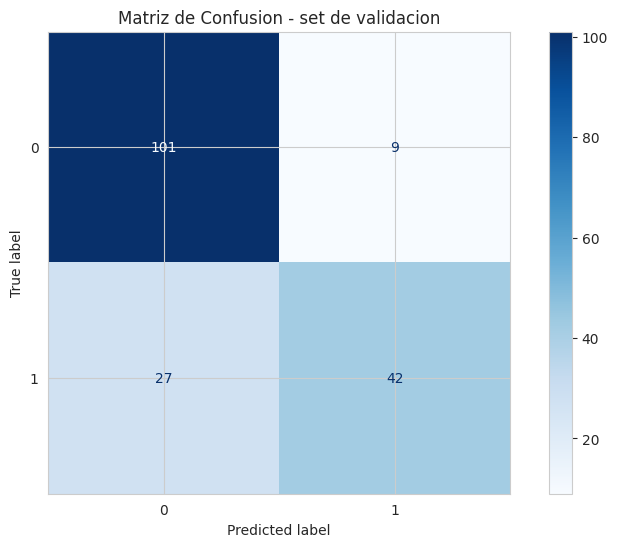

In [ ]:
# reporte de clasificacion y matriz de confusion
print("\nReporte de Clasificacion:")
print(classification_report(y_val, y_val_pred))

print("Matriz de Confusion:")
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusion - set de validacion')
plt.show()

Importancia de Features del modelo optimizado:


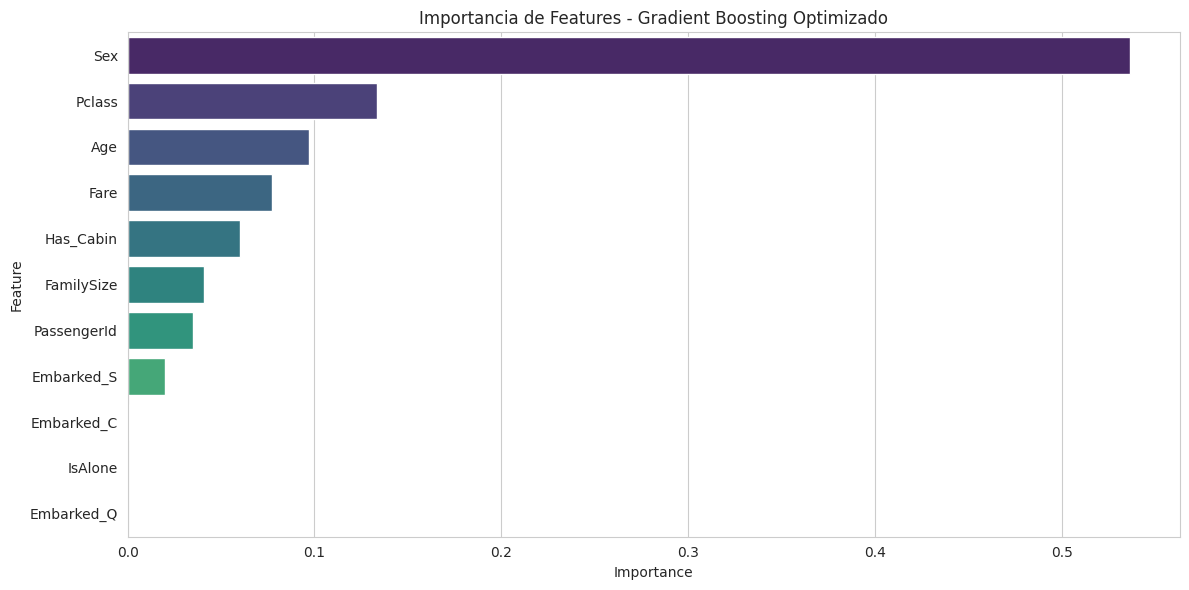

In [ ]:
# grafico de importancia de features
if hasattr(best_model, 'feature_importances_'):
    print("Importancia de Features del modelo optimizado:")
    importances = best_model.feature_importances_
    feature_names = X_train.columns
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis', hue='Feature')
    plt.title('Importancia de Features - Gradient Boosting Optimizado')
    plt.tight_layout()
    plt.show()

El modelo optimizado alcanza un acurracy de ~80% en el conjunto de validación, lo que confirma una mejorarespecto a la 

linea base y sugiere un buen trabajo de tuning. La matriz de confusión muestra un balance decente entre precision

y recall para ambas clases. El análisis de importancia de caracteristicas revela que `Fare`, `Sex`, `Title_Mr` y `Age`

fueron los predictores más importantes para el modelo, lo cual tiene sentido desde una perspectiva de dominio.

___

# GENERACION DE PREDICCIONES PARA KAGGLE

**OBJETIVO:** Usar el modelo final para predecir en el set de test de Kaggle y generar el archivo de submission

In [ ]:
# predecir en el set de test de Kaggle
# debemos asegurarnos de que test_df no tenga la columna 'Survived' y tenga las mismas features que X_train
X_test = test_df[X_train.columns]  # Asegurarse de que las columnas coincidan
test_predictions = best_model.predict(test_df)

# crear el archivo de submission
# necesitamos el PassengerId del set de test original, no los del preprocesado
test_original = pd.read_csv('/home/mz8k/kaggle-titanic-ml-pipeline/data/test.csv')
submission_df = pd.DataFrame({
    'PassengerId': test_original['PassengerId'],
    'Survived': test_predictions
})

# guardar el archivo de submission
submission_file_path = '/home/mz8k/kaggle-titanic-ml-pipeline/data/titanic_submission.csv'
submission_df.to_csv(submission_file_path, index=False)

print(f"Archivo de submission para Kaggle guardado en: {submission_file_path}")
print(f"Numero de predicciones: {len(submission_df)}")
print(f"Preview de las primeras predicciones: ")
print(submission_df.head(10))

Archivo de submission para Kaggle guardado en: /home/mz8k/kaggle-titanic-ml-pipeline/data/titanic_submission.csv
Numero de predicciones: 418
Preview de las primeras predicciones: 
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0
5          897         0
6          898         1
7          899         0
8          900         1
9          901         0


Finalmente, hemos utilizado nuestro modelo afinado para predecir la supervivencia en el conjunto de test oficial de Kaggle.

Las predicciones se han guardado en el formato requerido (`PassengerID`, `Survived`) en el archivo `titanic_submissions.csv

listo para ser subido a la plataforma y evaluado.

___